In [5]:
import Concord as ccd
import scanpy as sc
import torch
import warnings
warnings.filterwarnings('ignore')

adata = sc.datasets.pbmc3k_processed()
adata = adata.raw.to_adata()  # Store raw counts in adata.X, by default Concord will run standard total count normalization and log transformation internally

# Set device to cpu or to gpu (if your torch has been set up correctly to use GPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Select top variably expressed/accessible features for analysis (other methods besides seurat_v3 available)
feature_list = ccd.ul.select_features(adata, n_top_features=5000, flavor='seurat_v3')

# Initialize Concord with an AnnData object, skip input_feature default to all features
cur_ccd = ccd.Concord(adata=adata, input_feature=feature_list, device=device, use_faiss=False, verbose=False) 
# If integrating data across batch, simply add the domain_key argument
# cur_ccd = ccd.Concord(adata=adata, input_feature=feature_list, domain_key='batch', device=device) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
cur_ccd.encode_adata(input_layer_key='X_log1p', output_key='Concord')

Concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.


Epoch 0 Training: 41it [00:01, 38.28it/s, loss=4.35]
Epoch 4 Training: 100%|██████████| 41/41 [00:00<00:00, 41.87it/s, loss=4.1] 


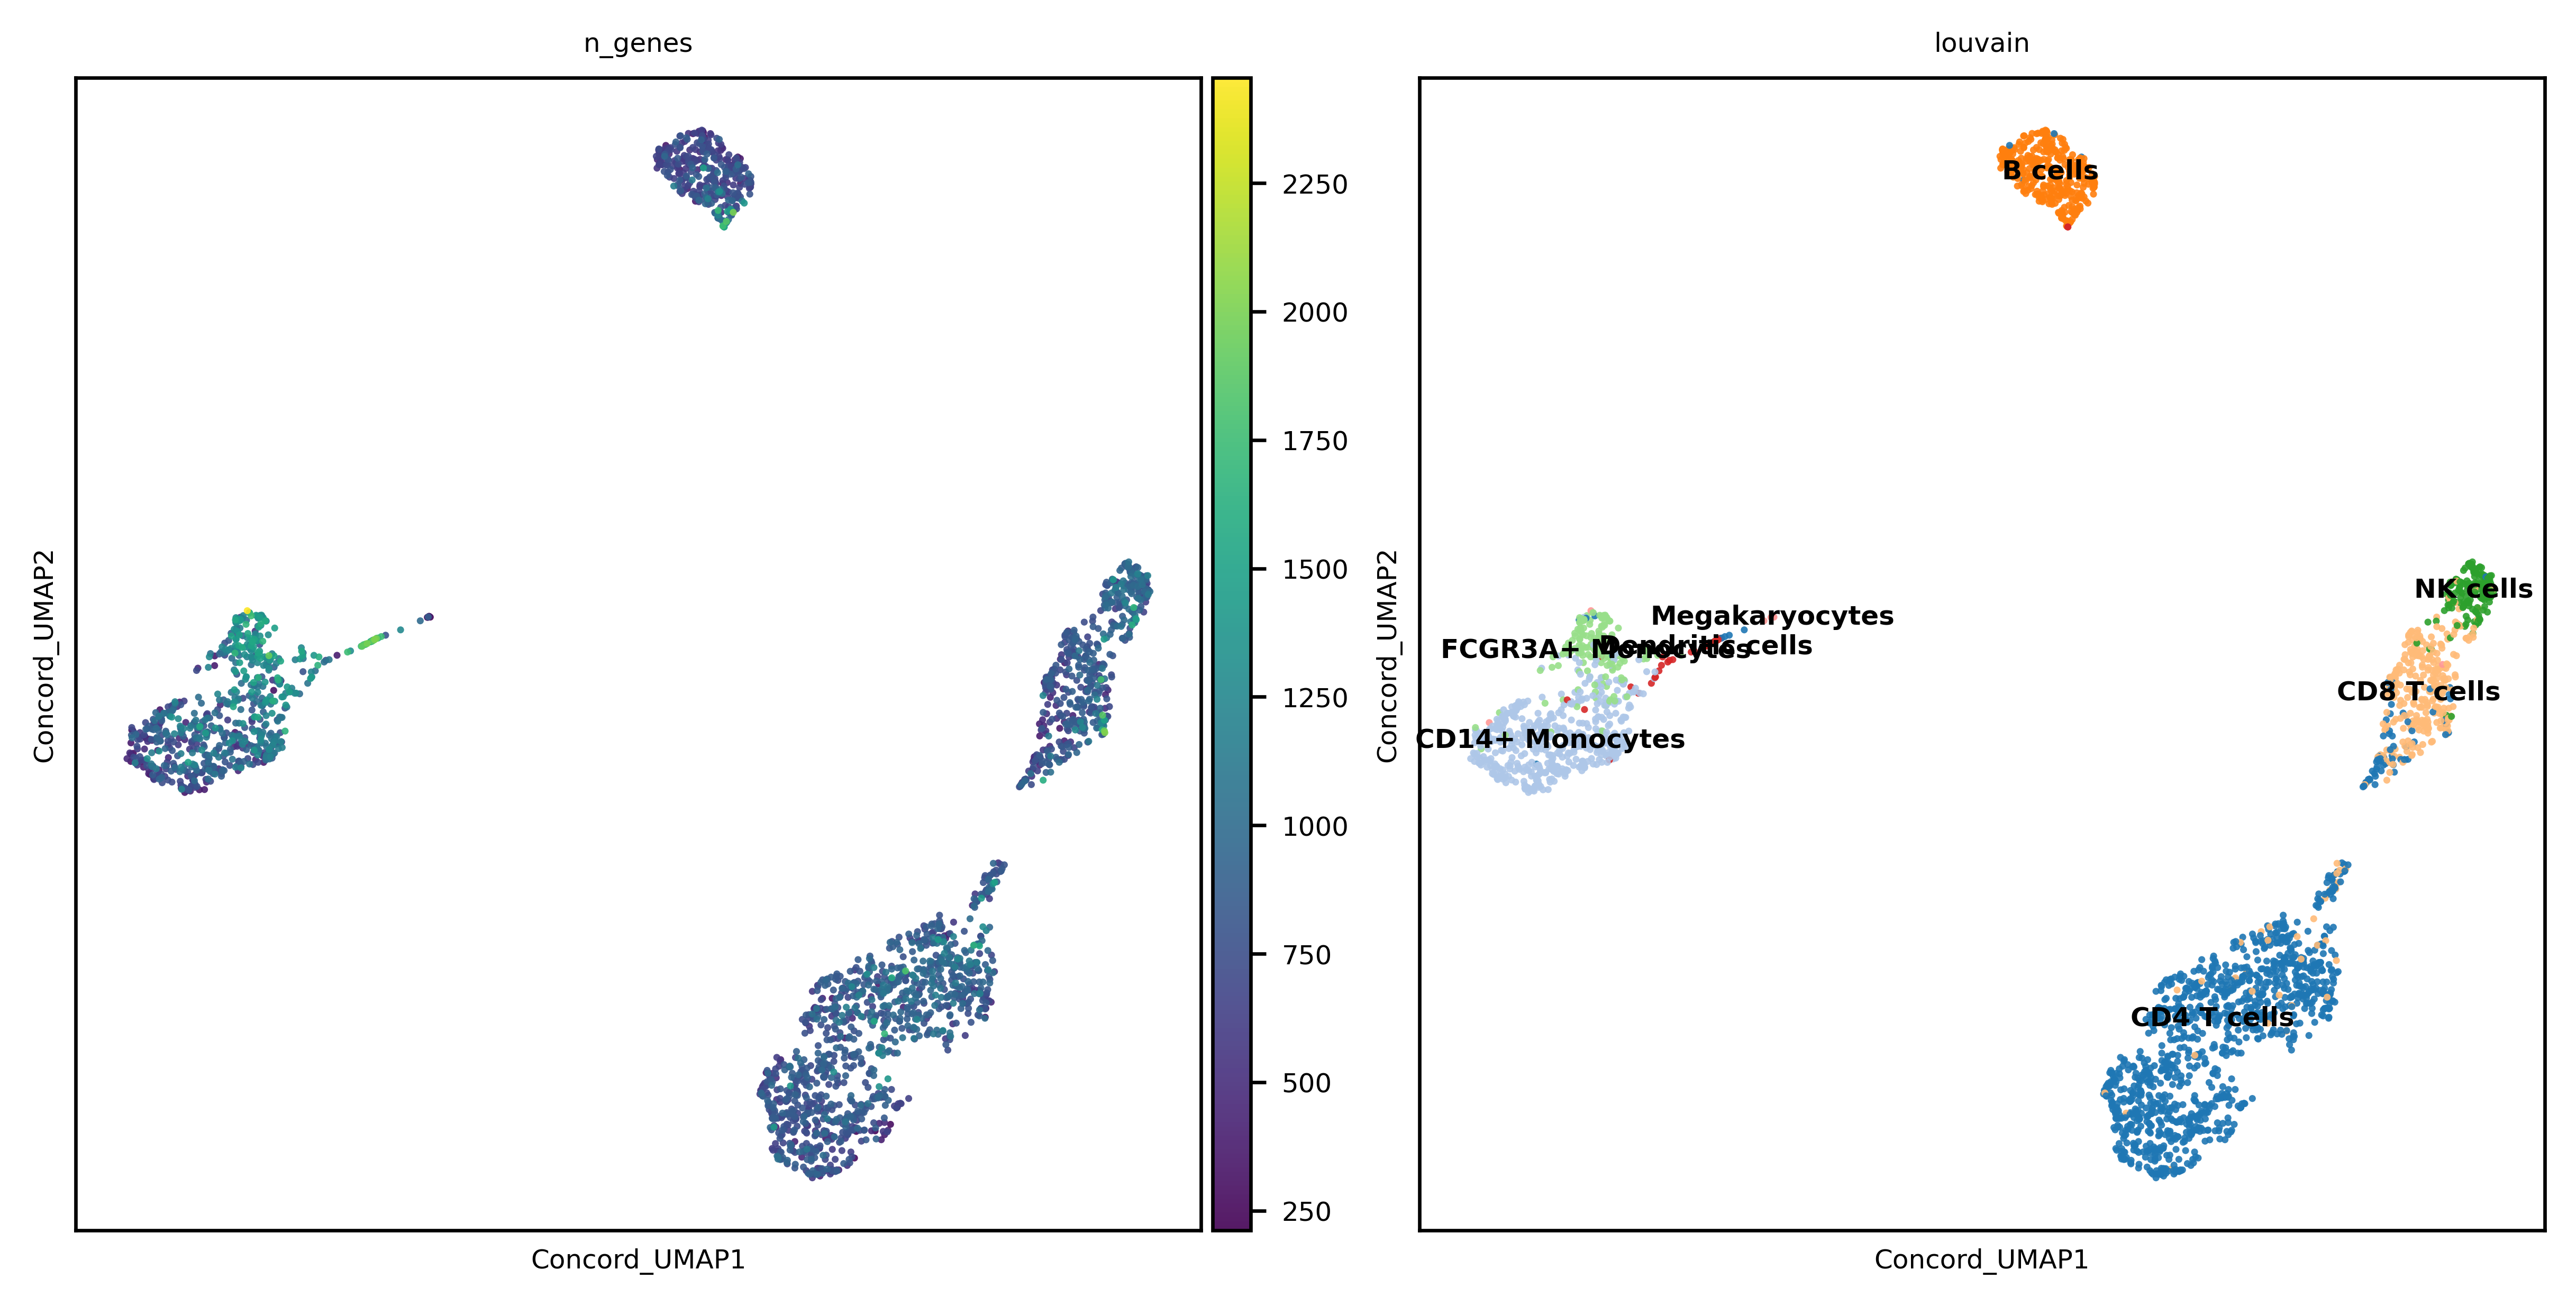

In [6]:
ccd.ul.run_umap(adata, source_key='Concord', umap_key='Concord_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')

# Plot the UMAP embeddings
color_by = ['n_genes', 'louvain'] # Choose which variables you want to visualize
ccd.pl.plot_embedding(
    adata, basis='Concord_UMAP', color_by=color_by, figsize=(8, 4), dpi=600, ncols=2, font_size=6, point_size=10, legend_loc='on data',
    save_path='Concord_UMAP.png'
)

We can compare to UMAP by scanpy:

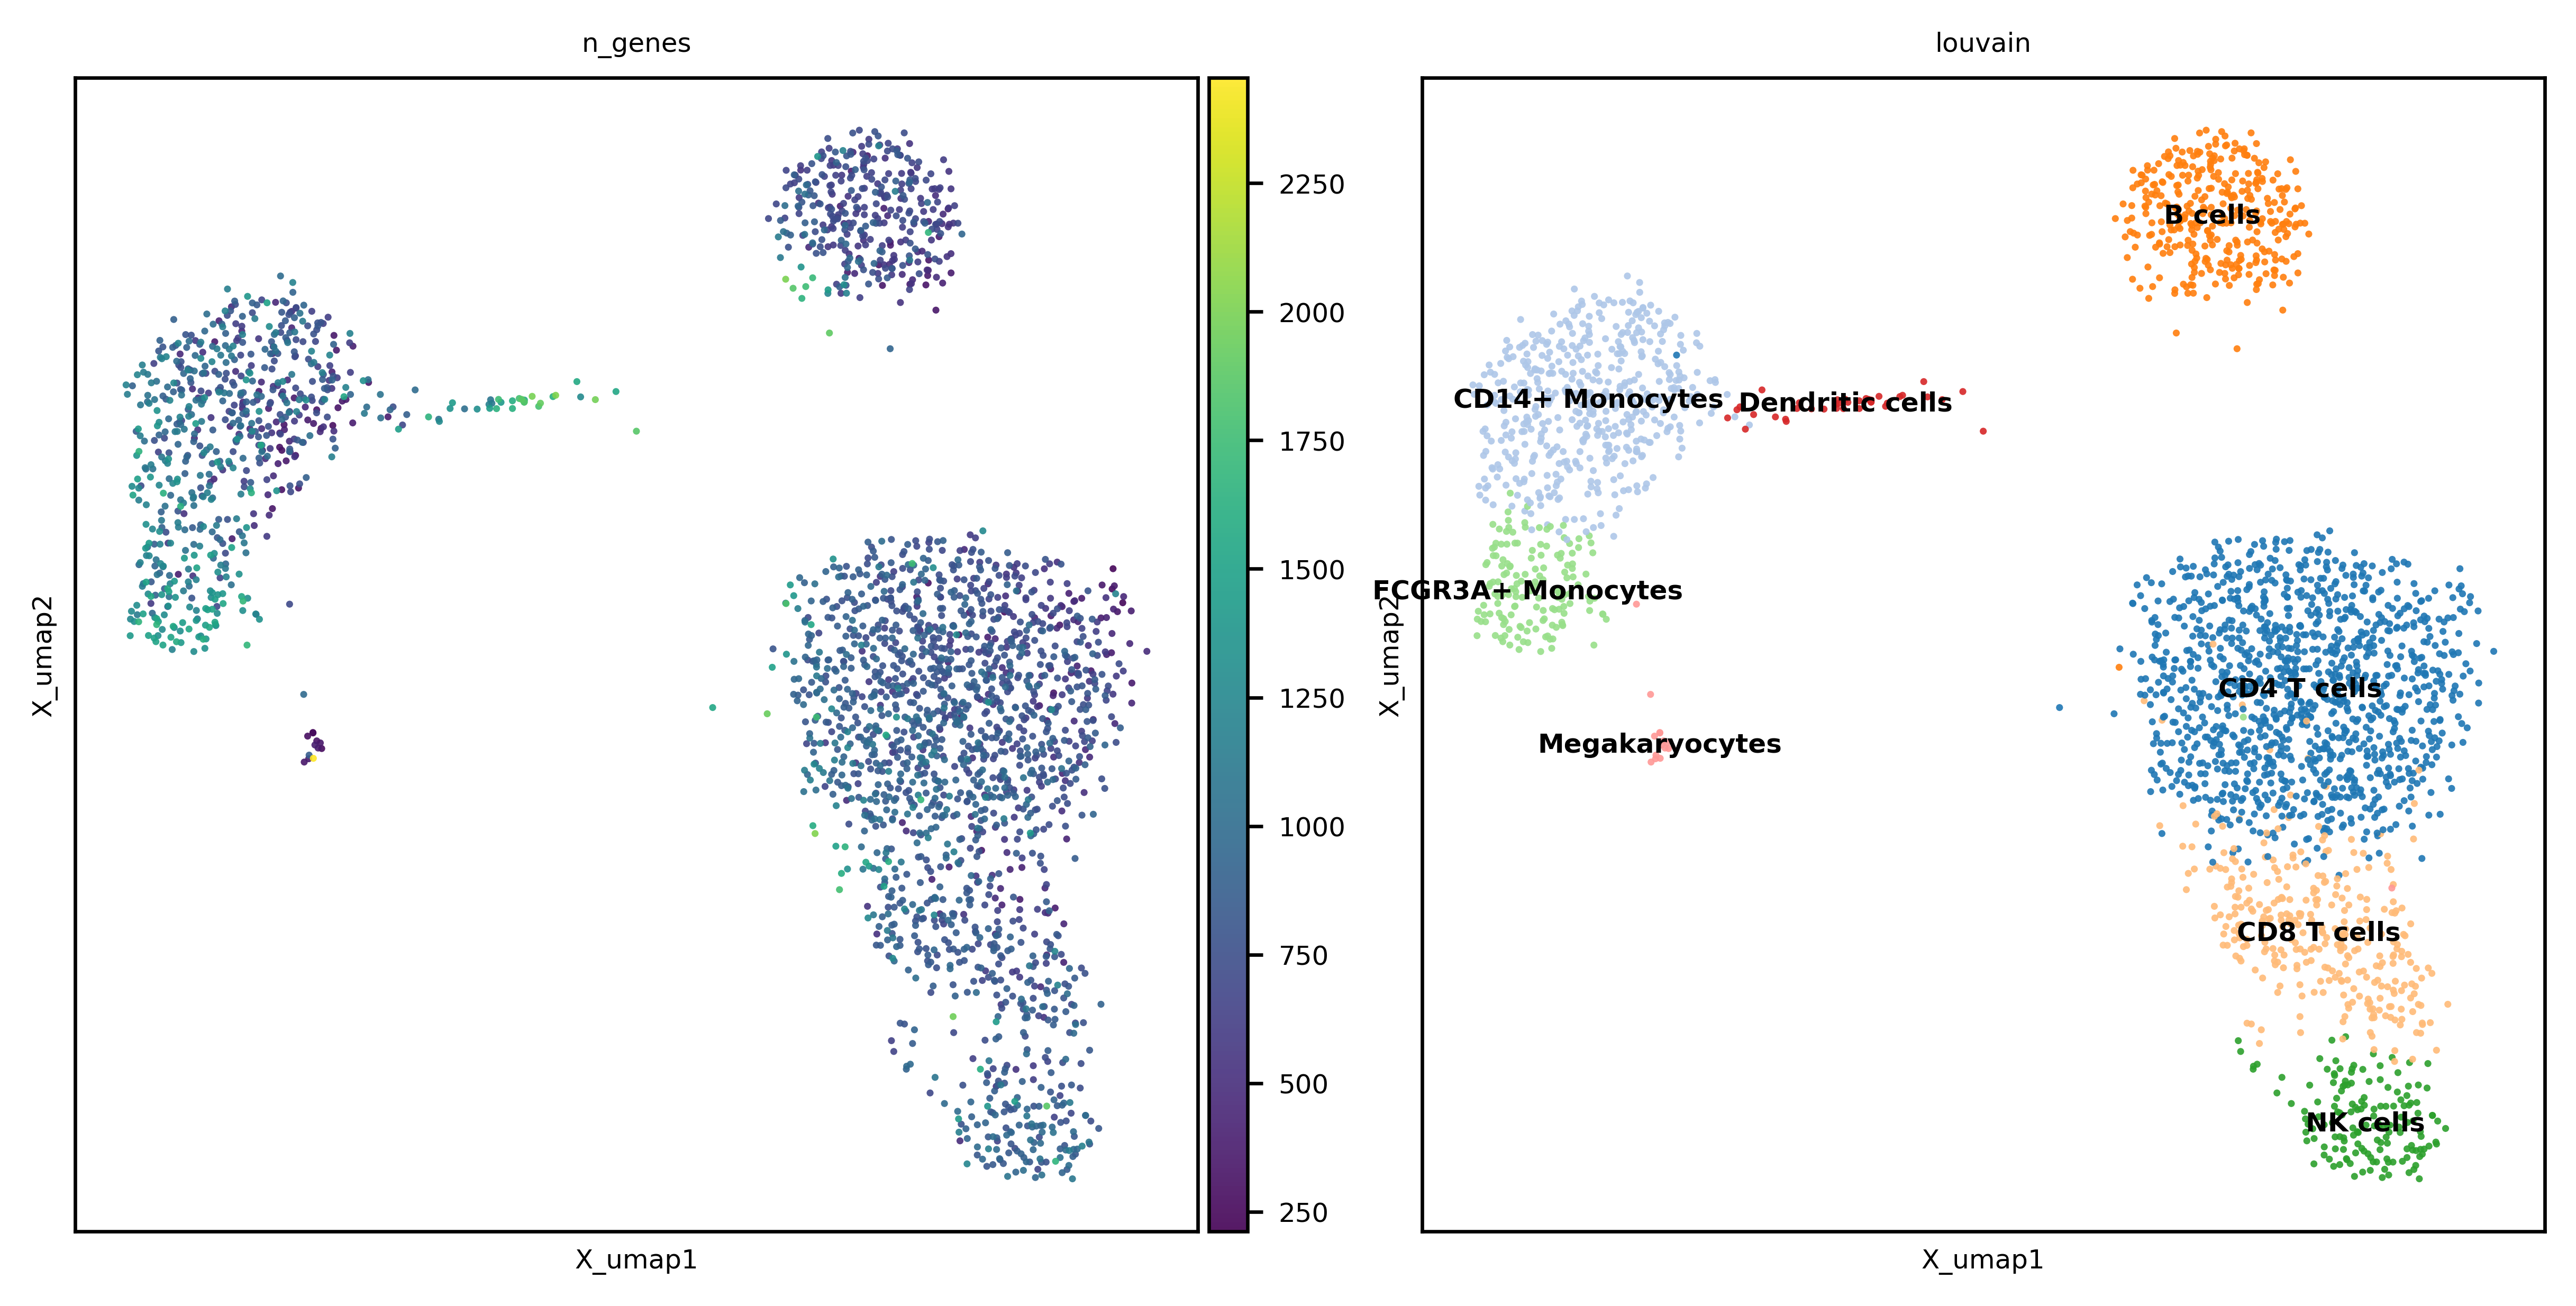

In [7]:
ccd.pl.plot_embedding(
    adata, basis='X_umap', color_by=color_by, figsize=(8, 4), dpi=600, ncols=2, font_size=6, point_size=10, legend_loc='on data',
    save_path='X_umap.png'
)

Concord result is best visualized with 3D UMAPs because 2D UMAP sometimes is not enough to unpack the learned latent structures:

In [8]:
import plotly.io as pio
pio.renderers.default = 'notebook'
ccd.ul.run_umap(adata, source_key='Concord', umap_key='Concord_UMAP_3D', n_components=3, n_neighbors=15, min_dist=0.1, metric='euclidean')

# Plot the 3D UMAP embeddings
col = 'louvain'
ccd.pl.plot_embedding_3d(
    adata, basis='Concord_UMAP_3D', color_by=col,
    save_path='Concord_UMAP_3D.html',
    point_size=1, opacity=0.8, width=1200, height=800
)